In [21]:
import pandas as pd
import numpy as np
from pykalman import KalmanFilter
import matplotlib.pyplot as plt

In [49]:
# Load Excel file
df = pd.read_excel("Extracted_Colors.xlsx")

# Display total number of entries
num_entries = len(df)
print(f"Total number of entries: {num_entries}")

# Define input and output columns
input_columns = ['R', 'G', 'B', 'L', 'a', 'b', 'H', 'S', 'V']
output_column = "pH"  # Assuming pH is the output column

# Original feature ranges
feature_ranges = {
    "R": (0, 150),
    "G": (50, 160),
    "B": (30, 180),
    "L": (20, 65),
    "a": (-20, 40),
    "b": (-60, 60),
    "H": (70, 220),
    "S": (35, 100),
    "V": (40, 75)
}

# Determine number of groups (every 10 rows)
num_groups = num_entries // 10  # Integer division to get the number of full groups
print(f"Processing {num_groups} groups of 10 rows each.")

Total number of entries: 410
Processing 41 groups of 10 rows each.


In [50]:
# Scaling functions
def min_max_scale(value, original_range):
    min_val, max_val = original_range
    return 2 * (value - min_val) / (max_val - min_val) - 1  # Scale to (-1,1)

def inverse_min_max_scale(value, original_range):
    min_val, max_val = original_range
    return (value + 1) * (max_val - min_val) / 2 + min_val  # Convert back to original scale

# Function to apply Kalman filtering on each group of 10 rows
def apply_kalman_filter(df_group, feature_ranges):
    df_filtered = df_group.copy()
    
    for col in input_columns:
        values = df_group[col].values.astype(float)
        
        # Scale to (-1,1) for stable Kalman filtering
        scaled_values = np.array([min_max_scale(v, feature_ranges[col]) for v in values])
        
        # Define Kalman filter (feature-specific noise settings)
        kf = KalmanFilter(
            initial_state_mean=scaled_values[0],  
            transition_matrices=[1],  
            observation_matrices=[1],  
            transition_covariance=0.001,  # Small process noise
            observation_covariance=0.01   # Observation noise
        )
        
        # Apply filter
        filtered_state_means, _ = kf.filter(scaled_values)
        
        # Convert back to original scale
        df_filtered[col] = [inverse_min_max_scale(v, feature_ranges[col]) for v in filtered_state_means.flatten()]
    
    return df_filtered

In [51]:
# Create a new DataFrame to store results
smoothed_df = pd.DataFrame()

# Apply Kalman filtering in fixed-size groups of 10 rows
for i in range(num_groups):
    start_idx = i * 10
    end_idx = start_idx + 10
    smoothed_df = pd.concat([smoothed_df, apply_kalman_filter(df.iloc[start_idx:end_idx], feature_ranges)])

# Keep the original pH column unchanged
smoothed_df["pH"] = df["pH"]

# Check the last few rows for correctness
print(smoothed_df.tail())

     Entry          R          G           B          L          a          b  \
405    406  19.871351  84.094447  161.884558  36.215392  11.299567 -45.805016   
406    407  21.719542  83.989047  162.812481  36.298959  11.936652 -46.210074   
407    408  18.878070  82.841006  159.566917  35.688638  11.168304 -45.286134   
408    409  15.744845  77.560264  162.519435  34.491440  15.534921 -48.954465   
409    410  23.511798  85.453081  163.130566  36.943886  11.538953 -45.386316   

              H          S          V    pH  
405  203.657338  88.929270  63.546965  10.0  
406  204.156713  88.069309  63.911979  10.0  
407  203.669678  89.451345  62.636678  10.0  
408  204.908651  91.199451  63.797076  10.0  
409  203.538158  87.119607  64.035471  10.0  


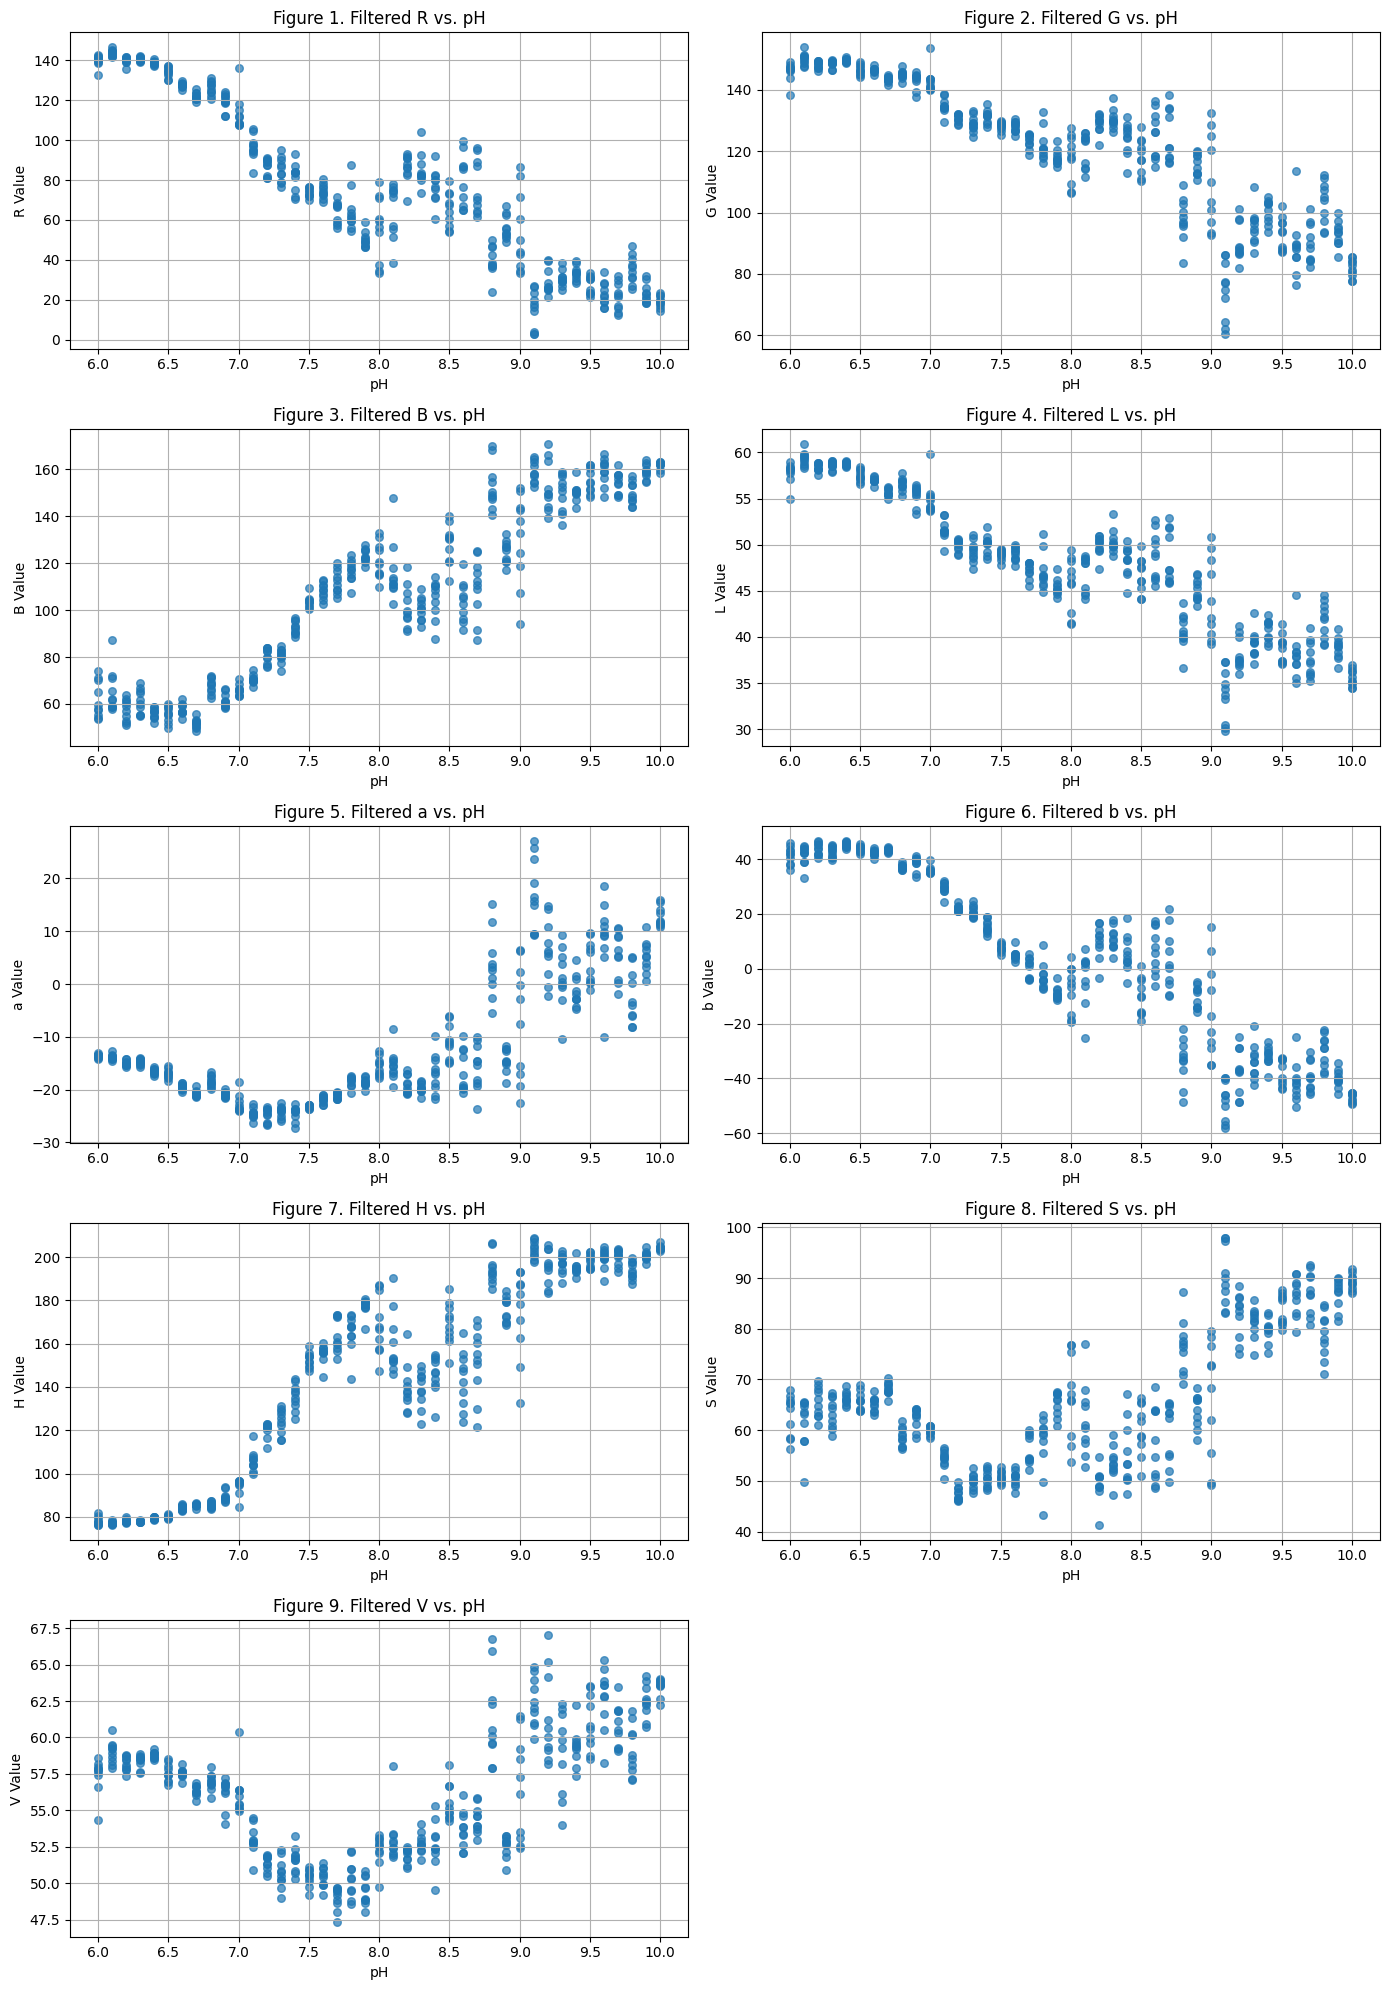

In [52]:
# Use the filtered/smoothed values
pH_values = smoothed_df["pH"].values
color_channels = ['R', 'G', 'B', 'L', 'a', 'b', 'H', 'S', 'V']

# Set up subplots
plt.figure(figsize=(14, 20))

for idx, channel in enumerate(color_channels):
    plt.subplot(5, 2, idx + 1)
    plt.scatter(pH_values, smoothed_df[channel].values, s=30, alpha=0.7)
    plt.xlabel("pH")
    plt.ylabel(f"{channel} Value")
    plt.title(f"Figure {idx+1}. Filtered {channel} vs. pH")
    plt.grid(True)

# Auto layout
plt.tight_layout()
plt.show()

In [53]:
# Save the filtered data to a new Excel file
smoothed_df.to_excel("filtered_data_kalman.xlsx", index=False)
print("Filtered dataset saved successfully as 'filtered_data_kalman_scaled.xlsx'!")

Filtered dataset saved successfully as 'filtered_data_kalman_scaled.xlsx'!
